# CS 439 Final Project - Disease Prediction ML Model


In [1]:
#!pip install pandas requests pyreadstat

In [2]:
import numpy as np
import pandas as pd
import pyreadstat
import requests
import re

## Data Processing

### Fetching the data

We are using data from NHANES (National Health and Nutrition Examination Survey). We are going to gather data that enacapsulates a wider range than traditional models, specifically data that isn't necessarily medical related.

links can be found at [https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2021-2023](https://)

In [3]:
from typing import ByteString
from io import BytesIO

def load_xpt(url):
  response = requests.get(url)
  if response.status_code != 200:
    raise Exception(f'failed to download {url}')
  return pd.read_sas(BytesIO(response.content), format='xport')

#base_url = 'https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/'
base_url = 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/'

urls = {
    'Demographics': base_url + 'DEMO_L.XPT',
    'Medical Conditions': base_url + 'MCQ_L.XPT',
    'Diabetes': base_url + 'DIQ_L.XPT',
    'Hypertension': base_url + 'BPQ_L.XPT',
    'Prescription Meds': base_url + 'RXQ_RX_L.XPT',
    'Plasma glucose': base_url + 'GLU_L.XPT',
    'CBC': base_url + 'CBC_L.XPT',
    'Body Measures': base_url + 'BMX_L.XPT',
    'Immunization': base_url + 'IMQ_L.XPT',
    'Physical Activity': base_url + 'PAQ_L.XPT',
    'Alchohol Use': base_url + 'ALQ_L.XPT',
    'Smoking': base_url + 'SMQ_L.XPT',
    'Diet': base_url + 'DBQ_L.XPT',
    'Health Insurance': base_url + 'HIQ_L.XPT',
    'Housing': base_url + 'HOQ_L.XPT',
    'Income and Food Security': base_url + 'INQ_L.XPT',
    'Pesticide Use': base_url + 'PUQMEC_L.XPT',
    'Occupational': base_url + 'OCQ_L.XPT',
    'Glycohemoglobin': base_url + 'GHB_L.XPT',
    'Oscillometric BP': base_url + 'BPXO_L.XPT'
}

data = {}
for name, url in urls.items():
  try:
    data[name] = load_xpt(url)
    print(f'loaded {name}')
  except Exception as e:
    print(f'Failed to load {name} : {e}')

df = data['Demographics'] #starting with demographics
for key in data:
  if key != 'Demographics':
    df = df.merge(data[key], on='SEQN', how='left')



loaded Demographics
loaded Medical Conditions
loaded Diabetes
loaded Hypertension
loaded Prescription Meds
loaded Plasma glucose
loaded CBC
loaded Body Measures
loaded Immunization
loaded Physical Activity
loaded Alchohol Use
loaded Smoking
loaded Diet
loaded Health Insurance
loaded Housing
loaded Income and Food Security
loaded Pesticide Use
loaded Occupational
loaded Glycohemoglobin
loaded Oscillometric BP


In [4]:
for name, df_mod in data.items():
    if 'DIQ010' in df_mod.columns:
        print(f'{name} has DIQ010')

Diabetes has DIQ010


In [5]:
print(df["DIQ010"].value_counts(dropna=False))

DIQ010
2.0    10371
1.0     1081
3.0      284
NaN      193
9.0        4
Name: count, dtype: int64


### Explore the Data

In [6]:
print(len(set(df.columns)))
print(set(df.columns))
print(f"Final merged shape: {df.shape}")
df.head()


211
{'SEQN', 'DBQ073B', 'DBQ935', 'MCQ160C', 'WTSAF2YR', 'MCQ560', 'DIQ160', 'SMD650', 'DBQ073D', 'LBXRBCSI', 'DMDHRAGZ', 'MCQ160E', 'DBQ370', 'DBD381', 'OCQ383', 'BPXOSY2', 'DMQMILIZ', 'MCQ160M', 'MCQ170M', 'BPXOSY3', 'DBQ400', 'HIQ032C', 'BMXWT', 'DIQ180', 'WTPH2YR_x', 'MCQ160B', 'MCQ170L', 'MCQ550', 'BPQ101D', 'DBQ424', 'HIQ011', 'BPXOPLS3', 'LBXMCVSI', 'SMD630', 'INDFMMPC', 'MCQ053', 'MCQ510A', 'BMIWAIST', 'SMD641', 'ALQ111', 'MCQ160D', 'PUQ100', 'BMXHT', 'MCQ040', 'LBXGH', 'DMDHSEDZ', 'HIQ210', 'LBXLYPCT', 'INDFMPIR', 'HIQ032I', 'DBD061', 'IND310', 'BMDBMIC', 'ALQ121', 'MCQ510B', 'DMDHRMAZ', 'LBXMOPCT', 'BPQ030', 'LBXHGB', 'DBQ073C', 'DIQ070', 'DBQ940', 'DMDYRUSR', 'MCQ010', 'BMIARMC', 'DBQ010', 'PAD820', 'MCQ510F', 'RXQ050', 'ALQ130', 'DBQ301', 'BPXOPLS2', 'RIDRETH1', 'MCQ230C', 'MCQ230B', 'MCQ510C', 'IMQ100', 'INDFMMPI', 'DBQ390', 'ALQ151', 'DMDHRGND', 'SDMVPSU', 'MCQ500', 'PAD790U', 'RIDEXMON', 'MCQ149', 'BMIHT', 'BMILEG', 'BMXARML', 'LBXMC', 'SDDSRVYR', 'SMD100MN', 'SMAQUEX2',

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,BPAOCSZ,BPXOSY1,BPXODI1,BPXOSY2,BPXODI2,BPXOSY3,BPXODI3,BPXOPLS1,BPXOPLS2,BPXOPLS3
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,4.0,135.0,98.0,131.0,96.0,132.0,94.0,82.0,79.0,82.0
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,4.0,121.0,84.0,117.0,76.0,113.0,76.0,72.0,71.0,73.0
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,4.0,111.0,79.0,112.0,80.0,104.0,76.0,84.0,83.0,77.0
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.to_csv('original_df.csv', index=False)
#be careful opening this.. ur computer might explode

### Clean the data

clean out columns with too many null values

In [8]:
# threshold = more than 90% are NaNs
threshold = 0.9

missing_ratio = df.isnull().mean() # ratios of missing val

columns_to_keep = missing_ratio[missing_ratio <= threshold].index

df_cleaned = df[columns_to_keep]

print(f"Remaining columns: {len(df_cleaned.columns)}")

Remaining columns: 164


drop col with non numeric values

In [9]:
df_cleaned = df_cleaned.loc[:, df_cleaned.apply(pd.api.types.is_numeric_dtype)]
print(df_cleaned.dtypes)
print(f"Remaining numeric columns: {df_cleaned.shape[1]}")

SEQN        float64
SDDSRVYR    float64
RIDSTATR    float64
RIAGENDR    float64
RIDAGEYR    float64
             ...   
BPXOSY3     float64
BPXODI3     float64
BPXOPLS1    float64
BPXOPLS2    float64
BPXOPLS3    float64
Length: 161, dtype: object
Remaining numeric columns: 161


drop duplicate and highly correlated col

In [10]:
# Convert all numeric columns to float for uniformity
df_temp = df_cleaned.astype(float)

# Drop columns with duplicate values (there's none here but just in case.)
df_cleaned = df_cleaned.loc[:, ~df_temp.T.duplicated()]

print(f"Columns after dropping duplicates: {df_cleaned.shape[1]}")

corr_matrix = df_cleaned.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] # > 90% similar

df_cleaned.drop(columns=to_drop, inplace=True)

print(f"Columns after dropping high corr col: {df_cleaned.shape[1]}")


Columns after dropping duplicates: 161
Columns after dropping high corr col: 139


In [11]:
print((len(df_cleaned.columns)))

139


Translate column code names to descriptions

In [12]:
#create new url dict for hml files to scrape
hml_urls = {
    name: re.sub(r'\.XPT$', '.htm', url, flags=re.IGNORECASE)
    for name, url in urls.items()
}
print(hml_urls)

{'Demographics': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm', 'Medical Conditions': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/MCQ_L.htm', 'Diabetes': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DIQ_L.htm', 'Hypertension': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BPQ_L.htm', 'Prescription Meds': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/RXQ_RX_L.htm', 'Plasma glucose': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/GLU_L.htm', 'CBC': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/CBC_L.htm', 'Body Measures': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.htm', 'Immunization': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/IMQ_L.htm', 'Physical Activity': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/PAQ_L.htm', 'Alchohol Use': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/ALQ_L.htm', 'Smoking':

In [13]:
#scrape variable names and labels from htm files
#go through each url and check to see if any of our codes exist in it
#scrape the sas labels for each code
from bs4 import BeautifulSoup

def extract_labels(url):
    try:
        resp = requests.get(url)
        soup = BeautifulSoup(resp.content, 'html.parser')
    except:
        print(f'theres an error in {url}')
    result = {}
    for dl in soup.find_all('dl'):
        dds = dl.find_all('dd')
        for code in df_cleaned.columns:
            cod = code.lower()
            if cod == dds[0].get_text(strip=True).lower():
                result[code] = dds[1].get_text(strip=True)
                print(f'found {code} in {url}')
    return result

code_map = {}

for name, url in hml_urls.items():
    code_map = code_map | extract_labels(url)

print(code_map)


found SEQN in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found SDDSRVYR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDSTATR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIAGENDR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDAGEYR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDRETH1 in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDEXMON in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMQMILIZ in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDBORN4 in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDYRUSR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDEDUC2 in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDMARTZ in https:/

In [14]:
#save code map to a file for ease of access
cm = pd.DataFrame(list(code_map.items()), columns=['Variable', 'SAS label'])
cm.to_csv('sas_labels.csv', index=False)

In [15]:
#testing nulls checkpoint
cols = df_cleaned.columns[df_cleaned.isnull().all()]
print('Fully null cols:', cols.tolist())

Fully null cols: []


### Separate the data

We want to split the data into x and y. X will be what we use to make a prediction on the variable y.

In [16]:
#first identify and split our data into x and y
target_cols = [
    'DIQ010',     # Diabetes
    'BPQ080',     # High cholesterol
    'MCQ160A',    # Arthritis
    'MCQ160B',    # Congestive heart failure
    'MCQ160C',    # Coronary heart disease
    'MCQ160D',    # Angina
    'MCQ160E',    # Heart attack
    'MCQ160F',    # Stroke
    'MCQ160L',    # Liver condition
    'MCQ160P',    # COPD/emphysema
    'MCQ220',     # Cancer
    'MCQ010',     # Asthma
]

#drop any rows with a missing value or 9 or 7 in target column
df_cleaned = df_cleaned.dropna(subset=target_cols)

for col in target_cols:
    df_cleaned = df_cleaned[df_cleaned[col] != 9.0]
    df_cleaned = df_cleaned[df_cleaned[col] != 7.0]

df_cleaned[target_cols] = df_cleaned[target_cols].replace(3.0, 1.0)

y = df_cleaned[target_cols]
X = df_cleaned.drop(columns=target_cols + ['SEQN'])

y = y.replace({2.0:0.0})

for col in target_cols:
    print(f'value counts for {col}:')
    print(df_cleaned[col].value_counts(dropna=False))
    print()


value counts for DIQ010:
DIQ010
2.0    6339
1.0    1268
Name: count, dtype: int64

value counts for BPQ080:
BPQ080
2.0    4643
1.0    2964
Name: count, dtype: int64

value counts for MCQ160A:
MCQ160A
2.0    5166
1.0    2441
Name: count, dtype: int64

value counts for MCQ160B:
MCQ160B
2.0    7302
1.0     305
Name: count, dtype: int64

value counts for MCQ160C:
MCQ160C
2.0    7232
1.0     375
Name: count, dtype: int64

value counts for MCQ160D:
MCQ160D
2.0    7437
1.0     170
Name: count, dtype: int64

value counts for MCQ160E:
MCQ160E
2.0    7308
1.0     299
Name: count, dtype: int64

value counts for MCQ160F:
MCQ160F
2.0    7258
1.0     349
Name: count, dtype: int64

value counts for MCQ160L:
MCQ160L
2.0    7201
1.0     406
Name: count, dtype: int64

value counts for MCQ160P:
MCQ160P
2.0    7078
1.0     529
Name: count, dtype: int64

value counts for MCQ220:
MCQ220
2.0    6473
1.0    1134
Name: count, dtype: int64

value counts for MCQ010:
MCQ010
2.0    6228
1.0    1379
Name: count, dt

In [17]:
#after eliminating rows that had a null in any target columns, 
#some cols in our non-target cols are now only have nulls. 
#We need to eliminate these
nulls = X.columns[X.isnull().all()]
print('Fully null columns:', nulls.tolist())

X = X.drop(columns=nulls)

Fully null columns: ['DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'MCQ500', 'BMDBMIC', 'DBQ010', 'DBD041', 'DBD055', 'DBD061', 'DBQ360', 'DBQ370', 'DBD381', 'DBQ400', 'DBD411', 'DBQ424']


Impute NULLs in X

In [18]:
from sklearn.impute import SimpleImputer

#Decide which columns in X should be imputed with mean or median based on skewedness
mean_cols = []
median_cols = []

for col in X.columns:
    if X[col].isnull().any():
        skew = X[col].skew()
        if abs(skew) > 1:
            median_cols.append(col)
        else:
            mean_cols.append(col)

imputers = []
if mean_cols:
    mean_imputer = SimpleImputer(strategy='mean')
    X_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(X[mean_cols]), columns=mean_cols, index=X.index)
    X[mean_cols] = X_mean_imputed
    imputers.append(('mean', mean_cols))

if median_cols:
    median_imputer = SimpleImputer(strategy='mean')
    X_median_imputed = pd.DataFrame(median_imputer.fit_transform(X[median_cols]), columns=median_cols, index=X.index)
    X[median_cols] = X_median_imputed
    imputers.append(('median', median_cols))

print(X.isnull().sum().sum())

0


### Split the data

Since we are using RandomForest, we wont need a validation set. so we will do 80% train and 20% test. There is also a class imbalance meaning our model is ignoring minority classes, because predicting all 0s gives high accuracy. To fix this, we are using oversampling.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Building the Model

Build the base model and wrap it in a MultiOutputClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

base_rf = RandomForestClassifier(class_weight='balanced',random_state=42, n_jobs=-1)

model = MultiOutputClassifier(base_rf)
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_jobs=-1,
                                                       random_state=42))

Make predictions on our model and evaluate its accuracy.

We needed to tune the probability thresholds for rarer diseases to handle imbalance. This greatly improved the model's performance.

In [21]:
from sklearn.metrics import classification_report, hamming_loss, f1_score

y_probs = model.predict_proba(X_test)

thresholds = {
    'MCQ160C': 0.25,
    'MCQ160D': 0.15,
    'MCQ160E': 0.20,
    'MCQ160F': 0.20,
    'MCQ160L': 0.10,
    'MCQ160P': 0.25,
    'MCQ220':  0.30,
    'MCQ160B': 0.25
}

y_pred_tuned = pd.DataFrame(index=y_test.index, columns=y_test.columns)

for i, col in enumerate(y_test.columns):
    threshold = thresholds.get(col, 0.5)
    y_pred_tuned[col] = (y_probs[i][:, 1] >= threshold).astype(int)

for col in y_test.columns:
    print(f"--- {col} ---")
    print(classification_report(y_test[col], y_pred_tuned[col], zero_division=0))
    print()

print("========== Overall Evaluation with Threshold Tuning ==========")
print(f"Hamming Loss: {hamming_loss(y_test, y_pred_tuned):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_tuned, average='macro'):.4f}")
print(f"Micro F1 Score: {f1_score(y_test, y_pred_tuned, average='micro'):.4f}")

--- DIQ010 ---
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1262
         1.0       1.00      0.89      0.94       260

    accuracy                           0.98      1522
   macro avg       0.99      0.95      0.97      1522
weighted avg       0.98      0.98      0.98      1522


--- BPQ080 ---
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85       898
         1.0       0.85      0.64      0.73       624

    accuracy                           0.80      1522
   macro avg       0.82      0.78      0.79      1522
weighted avg       0.81      0.80      0.80      1522


--- MCQ160A ---
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1030
         1.0       1.00      0.92      0.96       492

    accuracy                           0.97      1522
   macro avg       0.98      0.96      0.97      1522
weighted avg       0.98   

Some of the rarer diseases are heavily imbalanced, based on the recall scores, so we needed to perform some threshold tuning. After tuning, our Macros F1 score significantly improved, while our micro F1 score slightly dipped and our hamming loss slighlty rose, meaning we are catching the more rare cases, at the minor cost of overall prediction precision. Ultimately our model is balanced for detecting rare and common diseases. We can justify our fluctuations in micro F1 and hamming loss with our significantly improved Macro F1 score. In health applications, missing a condition is often worse than flagging a potential one incorrectly. Since we are using a multi-label RandomForest model with heavy imbalance, our macro F1 score of 0.4685 is more than ideal.

Feature importance analysis. We want to understand which features are driving the predictions for each disease.

In [22]:
def get_fi(model, X_cols, y_cols, top_n=10):
    all_imports = []

    for i, col in enumerate(y_cols):
        rf = model.estimators_[i]
        imps = rf.feature_importances_
        ranked = pd.DataFrame({
            'disease': col,
            'feature': X_cols,
            'importance': imps
        }).sort_values(by='importance', ascending=False).head(top_n)

        all_imports.append(ranked)
    return pd.concat(all_imports, ignore_index=True)


feature_importance_summ = get_fi(model, X.columns, y.columns, top_n=10)
print(feature_importance_summ)

    disease   feature  importance
0    DIQ010    DIQ160    0.288033
1    DIQ010    DIQ070    0.128108
2    DIQ010    DIQ180    0.116041
3    DIQ010     LBXGH    0.075686
4    DIQ010    RXQ050    0.035473
..      ...       ...         ...
115  MCQ010     BMXWT    0.008676
116  MCQ010  WTINT2YR    0.008393
117  MCQ010    RXQ050    0.007570
118  MCQ010  LBXEOPCT    0.007140
119  MCQ010  INDFMMPI    0.007035

[120 rows x 3 columns]


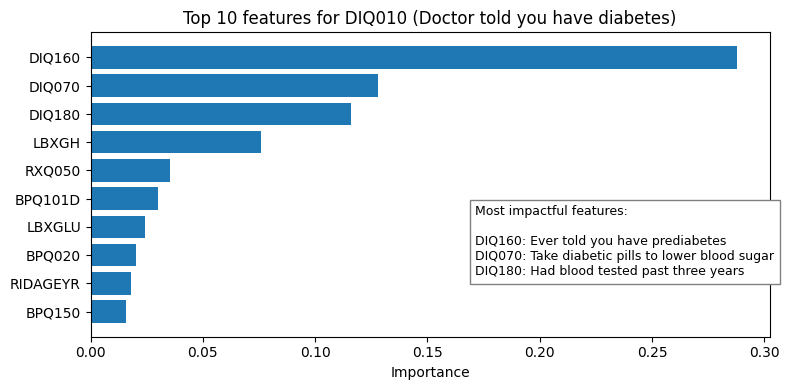

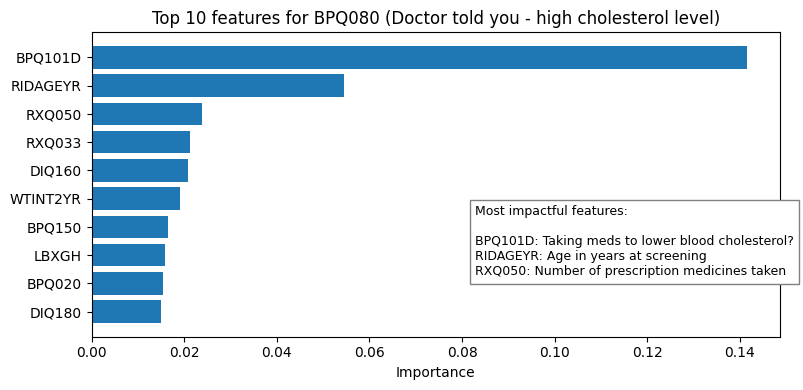

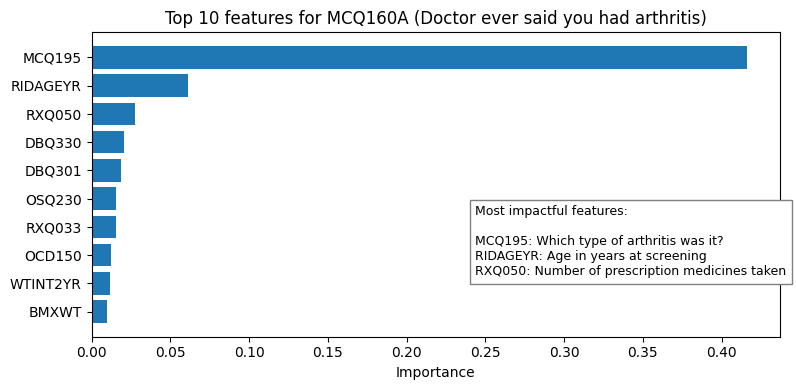

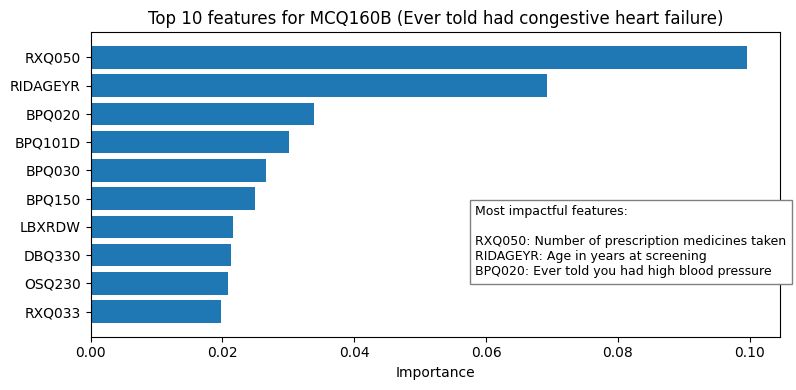

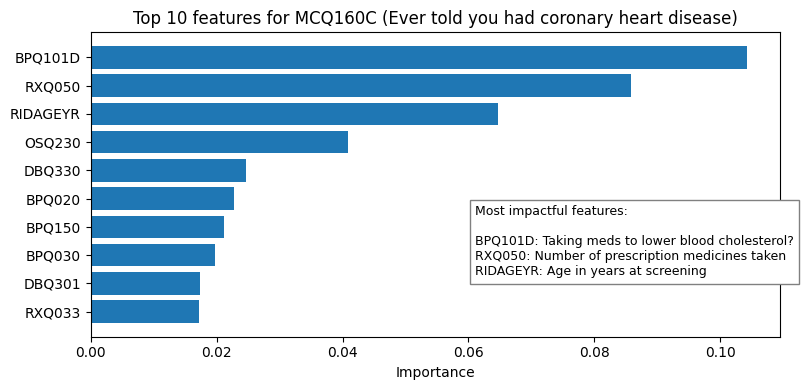

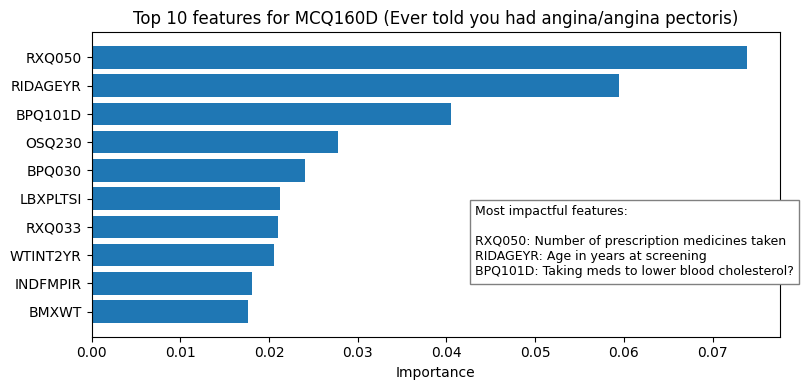

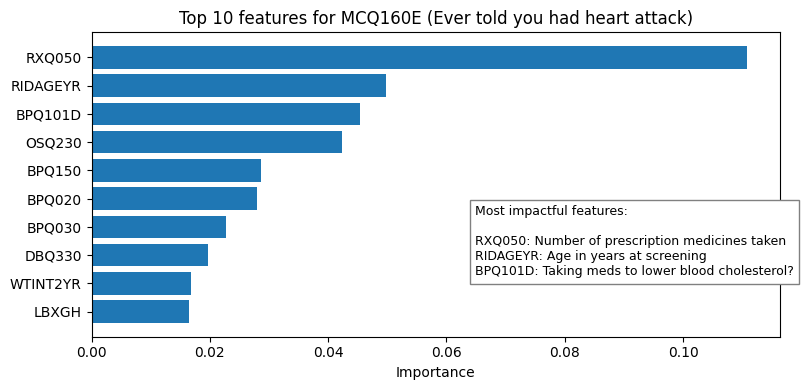

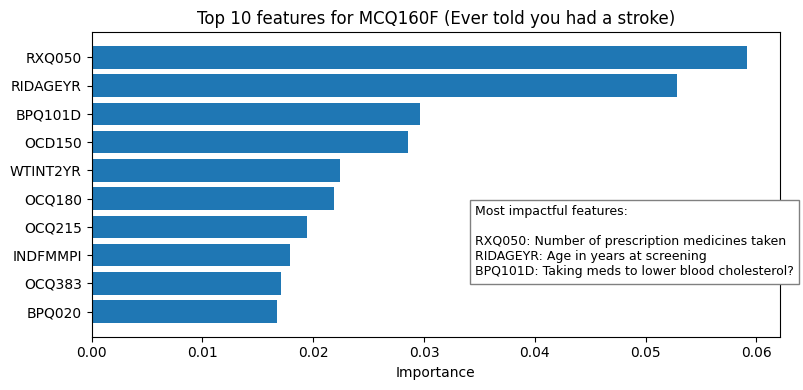

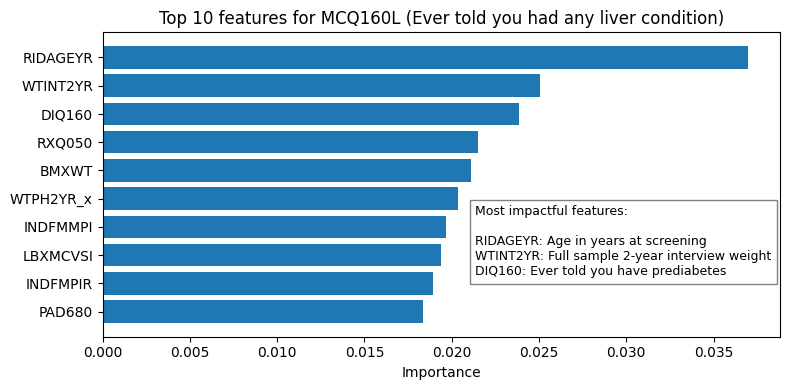

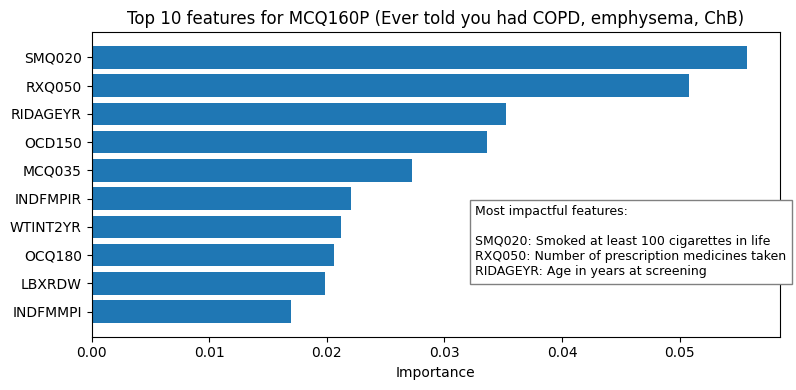

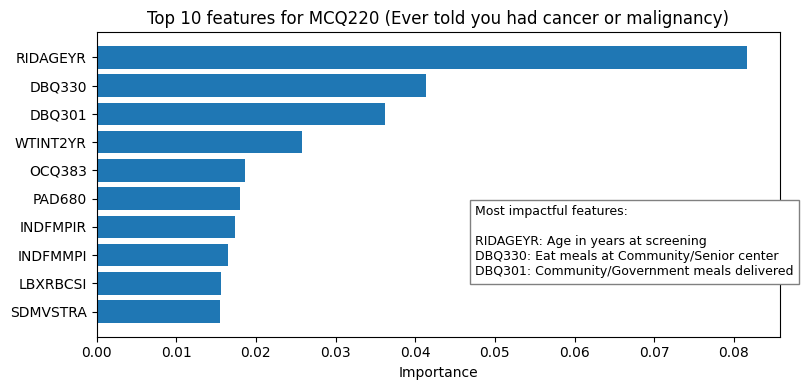

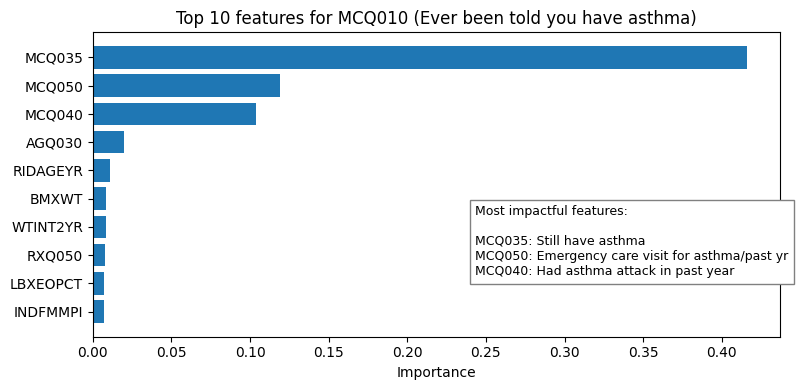

In [23]:
import matplotlib.pyplot as plt

def plot_top_feats(df, codes, top_n=10):
    diseases = df['disease'].unique()

    for disease in diseases:
        subset = df[df['disease'] == disease].sort_values(by='importance', ascending=True)

        top_feats = subset.sort_values(by='importance', ascending=False).head(3)['feature']
        desc = [f'{feat}: {codes.get(feat, 'Unknown')}' for feat in top_feats]
        plt.figure(figsize=(8,4))
        plt.barh(subset['feature'], subset['importance'])
        plt.title(f'Top {top_n} features for {disease} ({code_map[disease]})')
        plt.xlabel('Importance')
        box_lines = ['Most impactful features:', ''] + desc
        box_text = '\n'.join(box_lines)
        plt.gcf().text(0.6, 0.3, box_text, fontsize=9, bbox=dict(facecolor='white', edgecolor='gray'))
        plt.tight_layout()
        plt.show()

plot_top_feats(feature_importance_summ, code_map)

## Data Visualization and Evaluation